# Imports

In [1]:
import os
import json
import sys

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

from leaspy.main import Leaspy
from leaspy.inputs.data.data import Data
from leaspy.inputs.settings.algorithm_settings import AlgorithmSettings
from leaspy.utils.output.visualization.plotter import Plotter

# Step 1. Inputs

### - Data

In [4]:
data = Data.from_csv_file(os.path.join('_inputs', 'data.csv'))

### - Parameters

In [5]:
algo_settings = AlgorithmSettings('mcmc_saem')
algo_settings.set_logs('_outputs/logs/fit')

Do you want to erase the existing files in the output folder /Users/igor.koval/Documents/Work/leaspy/example/start/_outputs/logs/fit you provided? [y]/[n]y


# Step 2. Fit model

In [6]:
leaspy = Leaspy("multivariate_parallel")
leaspy.model.load_hyperparameters({'source_dimension': 2})

In [7]:
leaspy.fit(data, algorithm_settings=algo_settings)

Replacing n_burn_in_iter parameter from value 10000 to value 10000
Replacing n_iter parameter from value 9000 to value 9000
Replacing eps parameter from value 0.001 to value 0.001
Replacing L parameter from value 10 to value 10
Replacing sampler_ind parameter from value Gibbs to value Gibbs
Replacing sampler_pop parameter from value Gibbs to value Gibbs
Replacing annealing parameter from value {'do_annealing': True, 'initial_temperature': 300, 'n_plateau': 10, 'n_iter': 200} to value {'do_annealing': True, 'initial_temperature': 300, 'n_plateau': 10, 'n_iter': 200}
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 0
=Samplers 
    g rate : 4.0%, std: 0.005
    deltas rate : 0.0%, std: 0.005
    tau rate : 3.5806451612903225%, std: 0.1
    xi rate : 2.82258064516129%, std: 0.1
    sources rate : 3.612903225806452%, std: 0.1
    betas rate : 16.0%, std: 0.005
Annealing 
Temperature : 270.0
=== MODEL ===
g : 1.0007363557815552
tau_mean : 70.1201400756836
tau_std : 2.036902427673

/Users/igor.koval/Documents/Work/leaspy/example/start/../../leaspy/algo/samplers/abstract_sampler.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  accepted = torch.tensor(1. * (torch.rand(alpha.size(0)) < alpha), dtype=torch.float32)
/usr/local/lib/python3.7/site-packages/pandas/plotting/_core.py:998: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 50
=Samplers 
    g rate : 68.0%, std: 0.006050000000000001
    deltas rate : 64.0%, std: 0.008857805000000003
    tau rate : 98.758065700531%, std: 0.12100000000000002
    xi rate : 92.14516282081604%, std: 0.12100000000000002
    sources rate : 91.43548607826233%, std: 0.12100000000000002
    betas rate : 40.0%, std: 0.012968712300500009
Annealing 
Temperature : 210.0
=== MODEL ===
g : 1.088358759880066
tau_mean : 70.11672973632812
tau_std : 2.1147286891937256
xi_mean : -3.4130566120147705
xi_std : 0.7733626961708069
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.21795524656772614
deltas : tensor([-0.1363, -0.1610, -0.0013])
betas : tensor([[-0.0725, -0.0023],
        [-0.0582, -0.0063],
        [-0.0047,  0.0053]])

Duration since last print : 3.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 100
=Samplers 
    g rate : 72.0%, std: 0.0073205000000000015
    deltas rate : 44.0%, std: 0.01426558353055001
  

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 550
=Samplers 
    g rate : 24.0%, std: 0.027799586567461194
    deltas rate : 16.0%, std: 0.06296704055739022
    tau rate : 71.29032015800476%, std: 0.8140274938683988
    xi rate : 38.790321350097656%, std: 0.6115909044841462
    sources rate : 35.290321707725525%, std: 0.3138428376721002
    betas rate : 12.0%, std: 0.004498488156784778
Annealing 
Temperature : 1
=== MODEL ===
g : 1.2118717432022095
tau_mean : 70.26937103271484
tau_std : 3.998302459716797
xi_mean : -2.27223801612854
xi_std : 1.3087621927261353
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.0990753099322319
deltas : tensor([-2.2866, -2.4434, -1.1858])
betas : tensor([[-0.1569, -0.0146],
        [-0.0825,  0.0202],
        [ 0.0278,  0.0792]])

Duration since last print : 3.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 600
=Samplers 
    g rate : 40.0%, std: 0.027799586567461194
    deltas rate : 32.0%, std: 0.06857110716699796
    tau r

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 1050
=Samplers 
    g rate : 24.0%, std: 0.036631237224077955
    deltas rate : 28.000000000000004%, std: 0.04850363352379957
    tau rate : 37.01612949371338%, std: 2.5547669861876656
    xi rate : 34.51612889766693%, std: 0.6115909044841462
    sources rate : 37.98387050628662%, std: 0.45949729863572203
    betas rate : 20.0%, std: 0.00525414636388569
Annealing 
Temperature : 1
=== MODEL ===
g : 0.8177700638771057
tau_mean : 71.45036315917969
tau_std : 7.5748114585876465
xi_mean : -1.707499623298645
xi_std : 0.9318948984146118
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.09448754787445068
deltas : tensor([-2.7650, -2.4630, -1.1462])
betas : tensor([[-0.0812,  0.0368],
        [-0.0443,  0.0306],
        [-0.0189,  0.0928]])

Duration since last print : 3.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 1100
=Samplers 
    g rate : 20.0%, std: 0.03296811350167016
    deltas rate : 28.000000000000004%, std:

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 1550
=Samplers 
    g rate : 32.0%, std: 0.039891417337020896
    deltas rate : 36.0%, std: 0.05073912015164243
    tau rate : 36.19354963302612%, std: 2.5547669861876656
    xi rate : 36.14516258239746%, std: 0.6115909044841462
    sources rate : 37.1129035949707%, std: 0.5054470284992942
    betas rate : 32.0%, std: 0.004191476265657531
Annealing 
Temperature : 1
=== MODEL ===
g : 0.7177658081054688
tau_mean : 72.56598663330078
tau_std : 7.5006279945373535
xi_mean : -1.6473288536071777
xi_std : 0.897354245185852
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.09388904273509979
deltas : tensor([-3.0380, -2.4690, -1.0216])
betas : tensor([[-0.0905,  0.0385],
        [-0.0380,  0.0271],
        [-0.0381,  0.0974]])

Duration since last print : 3.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 1600
=Samplers 
    g rate : 24.0%, std: 0.03590227560331881
    deltas rate : 32.0%, std: 0.05581303216680668
    tau 

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 2050
=Samplers 
    g rate : 20.0%, std: 0.03135234790406219
    deltas rate : 24.0%, std: 0.058385402069919996
    tau rate : 37.5%, std: 2.5547669861876656
    xi rate : 36.32258176803589%, std: 0.6115909044841462
    sources rate : 37.95161247253418%, std: 0.5054470284992942
    betas rate : 36.0%, std: 0.006715449200859248
Annealing 
Temperature : 1
=== MODEL ===
g : 0.6930258274078369
tau_mean : 72.5737075805664
tau_std : 7.237398147583008
xi_mean : -1.6653573513031006
xi_std : 0.9445416927337646
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.09485486149787903
deltas : tensor([-2.8367, -2.4558, -1.0400])
betas : tensor([[-0.0773,  0.0492],
        [-0.0414,  0.0435],
        [-0.0253,  0.0979]])

Duration since last print : 3.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 2100
=Samplers 
    g rate : 24.0%, std: 0.03135234790406219
    deltas rate : 28.000000000000004%, std: 0.0578015480492208
    tau 

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 2550
=Samplers 
    g rate : 40.0%, std: 0.03718140777873334
    deltas rate : 28.000000000000004%, std: 0.06786258896743923
    tau rate : 37.129032611846924%, std: 2.5547669861876656
    xi rate : 38.40322494506836%, std: 0.6115909044841462
    sources rate : 37.04838752746582%, std: 0.5054470284992942
    betas rate : 36.0%, std: 0.005952472578419815
Annealing 
Temperature : 1
=== MODEL ===
g : 0.6320196390151978
tau_mean : 73.27977752685547
tau_std : 7.538491725921631
xi_mean : -1.74485445022583
xi_std : 0.9485334157943726
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.09449120610952377
deltas : tensor([-2.7354, -2.4617, -1.0473])
betas : tensor([[-0.0779,  0.0376],
        [-0.0415,  0.0417],
        [-0.0271,  0.1126]])

Duration since last print : 3.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 2600
=Samplers 
    g rate : 24.0%, std: 0.03718140777873334
    deltas rate : 28.000000000000004%, std: 0

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 3050
=Samplers 
    g rate : 24.0%, std: 0.03346326700086001
    deltas rate : 20.0%, std: 0.06199364548064883
    tau rate : 32.64515995979309%, std: 2.5547669861876656
    xi rate : 36.29032373428345%, std: 0.6115909044841462
    sources rate : 34.46774184703827%, std: 0.5559917313492238
    betas rate : 32.0%, std: 0.005803799807098075
Annealing 
Temperature : 1
=== MODEL ===
g : 0.6043387651443481
tau_mean : 73.21149444580078
tau_std : 7.509316444396973
xi_mean : -1.5647332668304443
xi_std : 0.8369392156600952
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.09414871037006378
deltas : tensor([-2.8734, -2.5026, -1.1272])
betas : tensor([[-0.0695,  0.0534],
        [-0.0318,  0.0473],
        [-0.0062,  0.1163]])

Duration since last print : 4.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 3100
=Samplers 
    g rate : 44.0%, std: 0.03312863433085141
    deltas rate : 40.0%, std: 0.05021485283932556
    tau 

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 3550
=Samplers 
    g rate : 20.0%, std: 0.03246937450766747
    deltas rate : 24.0%, std: 0.051483876709962746
    tau rate : 34.08064544200897%, std: 2.5547669861876656
    xi rate : 38.290321826934814%, std: 0.6115909044841462
    sources rate : 36.6451621055603%, std: 0.5559917313492238
    betas rate : 24.0%, std: 0.0057160003860897
Annealing 
Temperature : 1
=== MODEL ===
g : 0.5267534852027893
tau_mean : 73.86909484863281
tau_std : 7.740797519683838
xi_mean : -1.5872225761413574
xi_std : 0.8662208318710327
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.09439892321825027
deltas : tensor([-2.9918, -2.4849, -1.0024])
betas : tensor([[-0.0694,  0.0608],
        [-0.0250,  0.0412],
        [ 0.0036,  0.1101]])

Duration since last print : 3.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 3600
=Samplers 
    g rate : 28.000000000000004%, std: 0.03246937450766747
    deltas rate : 24.0%, std: 0.0566322643809

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 4050
=Samplers 
    g rate : 28.000000000000004%, std: 0.028930212686331717
    deltas rate : 20.0%, std: 0.05331815273030227
    tau rate : 34.7258061170578%, std: 2.5547669861876656
    xi rate : 37.70967721939087%, std: 0.6115909044841462
    sources rate : 34.112903475761414%, std: 0.5559917313492238
    betas rate : 20.0%, std: 0.006880535673887429
Annealing 
Temperature : 1
=== MODEL ===
g : 0.48953989148139954
tau_mean : 73.66259765625
tau_std : 7.676544189453125
xi_mean : -1.6585471630096436
xi_std : 0.876937985420227
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.09415460377931595
deltas : tensor([-2.8422, -2.4935, -1.1598])
betas : tensor([[-0.0745,  0.0545],
        [-0.0362,  0.0450],
        [-0.0140,  0.1131]])

Duration since last print : 3.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 4100
=Samplers 
    g rate : 28.000000000000004%, std: 0.028930212686331717
    deltas rate : 24.0%, std: 0

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 4550
=Samplers 
    g rate : 40.0%, std: 0.03773984143510594
    deltas rate : 36.0%, std: 0.055775535998122606
    tau rate : 35.25806367397308%, std: 2.5547669861876656
    xi rate : 35.16128957271576%, std: 0.6115909044841462
    sources rate : 33.935484290122986%, std: 0.5559917313492238
    betas rate : 32.0%, std: 0.004818263618834218
Annealing 
Temperature : 1
=== MODEL ===
g : 0.6190003752708435
tau_mean : 72.77386474609375
tau_std : 7.908425331115723
xi_mean : -1.6331998109817505
xi_std : 0.8726078867912292
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.09362737089395523
deltas : tensor([-3.0726, -2.4972, -1.1275])
betas : tensor([[-0.0837,  0.0572],
        [-0.0330,  0.0377],
        [-0.0189,  0.1073]])

Duration since last print : 3.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 4600
=Samplers 
    g rate : 28.000000000000004%, std: 0.03773984143510594
    deltas rate : 40.0%, std: 0.0613530895

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 5050
=Samplers 
    g rate : 24.0%, std: 0.0336261987186794
    deltas rate : 24.0%, std: 0.053041979762053895
    tau rate : 36.08064651489258%, std: 2.5547669861876656
    xi rate : 36.000001430511475%, std: 0.6115909044841462
    sources rate : 33.80645215511322%, std: 0.5559917313492238
    betas rate : 40.0%, std: 0.005219910641824837
Annealing 
Temperature : 1
=== MODEL ===
g : 0.6390951871871948
tau_mean : 72.44766998291016
tau_std : 7.439275741577148
xi_mean : -1.6858932971954346
xi_std : 0.8985198140144348
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.09457909315824509
deltas : tensor([-2.9504, -2.5029, -1.2421])
betas : tensor([[-0.0770,  0.0548],
        [-0.0363,  0.0392],
        [-0.0122,  0.1019]])

Duration since last print : 3.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 5100
=Samplers 
    g rate : 24.0%, std: 0.0336261987186794
    deltas rate : 36.0%, std: 0.053041979762053895
    tau

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 5550
=Samplers 
    g rate : 32.0%, std: 0.030263578846811457
    deltas rate : 36.0%, std: 0.05044239498071044
    tau rate : 35.12903153896332%, std: 2.5547669861876656
    xi rate : 34.75806415081024%, std: 0.6115909044841462
    sources rate : 36.58064603805542%, std: 0.5559917313492238
    betas rate : 20.0%, std: 0.005542503404916578
Annealing 
Temperature : 1
=== MODEL ===
g : 0.7567740082740784
tau_mean : 72.29325866699219
tau_std : 7.286360263824463
xi_mean : -1.631678819656372
xi_std : 0.8447802662849426
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.09406799077987671
deltas : tensor([-2.8441, -2.5150, -1.1106])
betas : tensor([[-0.0757,  0.0344],
        [-0.0449,  0.0316],
        [-0.0374,  0.0861]])

Duration since last print : 4.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 5600
=Samplers 
    g rate : 20.0%, std: 0.030263578846811457
    deltas rate : 28.000000000000004%, std: 0.05044239498

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 6050
=Samplers 
    g rate : 24.0%, std: 0.036252741100595454
    deltas rate : 40.0%, std: 0.04231404758426193
    tau rate : 35.91935336589813%, std: 2.5547669861876656
    xi rate : 35.95161437988281%, std: 0.6115909044841462
    sources rate : 34.43548381328583%, std: 0.5559917313492238
    betas rate : 24.0%, std: 0.0043335239627511814
Annealing 
Temperature : 1
=== MODEL ===
g : 0.7622416019439697
tau_mean : 72.35636901855469
tau_std : 7.338138103485107
xi_mean : -1.6507676839828491
xi_std : 0.9414831399917603
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.09472793340682983
deltas : tensor([-2.9324, -2.5621, -1.0225])
betas : tensor([[-0.0762,  0.0509],
        [-0.0352,  0.0398],
        [-0.0188,  0.0905]])

Duration since last print : 5.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 6100
=Samplers 
    g rate : 32.0%, std: 0.036252741100595454
    deltas rate : 40.0%, std: 0.051199997576956945
    

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 6550
=Samplers 
    g rate : 36.0%, std: 0.036252741100595454
    deltas rate : 32.0%, std: 0.05951084119516579
    tau rate : 35.38709580898285%, std: 2.5547669861876656
    xi rate : 37.67741918563843%, std: 0.6115909044841462
    sources rate : 37.48387098312378%, std: 0.5559917313492238
    betas rate : 28.000000000000004%, std: 0.0046478157989804
Annealing 
Temperature : 1
=== MODEL ===
g : 0.5712577700614929
tau_mean : 73.24140167236328
tau_std : 7.358285427093506
xi_mean : -1.6667951345443726
xi_std : 0.9072689414024353
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.09422793984413147
deltas : tensor([-2.9640, -2.4578, -1.1278])
betas : tensor([[-0.0781,  0.0238],
        [-0.0306,  0.0263],
        [-0.0434,  0.0870]])

Duration since last print : 4.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 6600
=Samplers 
    g rate : 24.0%, std: 0.036252741100595454
    deltas rate : 32.0%, std: 0.058326575455

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 7050
=Samplers 
    g rate : 48.0%, std: 0.035531311552693616
    deltas rate : 28.000000000000004%, std: 0.06040464427115997
    tau rate : 37.98387050628662%, std: 2.5547669861876656
    xi rate : 37.29032278060913%, std: 0.6727499949325609
    sources rate : 34.822580218315125%, std: 0.5559917313492238
    betas rate : 24.0%, std: 0.006216363472995047
Annealing 
Temperature : 1
=== MODEL ===
g : 0.49123769998550415
tau_mean : 73.40581512451172
tau_std : 8.147552490234375
xi_mean : -1.8141398429870605
xi_std : 0.9985471963882446
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.09480904042720795
deltas : tensor([-3.0334, -2.4880, -1.0652])
betas : tensor([[-0.0931,  0.0480],
        [-0.0379,  0.0394],
        [-0.0467,  0.1045]])

Duration since last print : 4.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 7100
=Samplers 
    g rate : 32.0%, std: 0.035531311552693616
    deltas rate : 36.0%, std: 0.06040464

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 7550
=Samplers 
    g rate : 24.0%, std: 0.03447599606826707
    deltas rate : 16.0%, std: 0.05222201424511108
    tau rate : 34.79032218456268%, std: 2.5547669861876656
    xi rate : 34.354838728904724%, std: 0.6727499949325609
    sources rate : 35.274192690849304%, std: 0.5559917313492238
    betas rate : 44.0%, std: 0.005454989634156039
Annealing 
Temperature : 1
=== MODEL ===
g : 0.6038658618927002
tau_mean : 73.22628784179688
tau_std : 7.583866119384766
xi_mean : -1.652427315711975
xi_std : 0.8538299798965454
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.09361457824707031
deltas : tensor([-2.8341, -2.4703, -1.0307])
betas : tensor([[-0.0720,  0.0388],
        [-0.0337,  0.0405],
        [-0.0376,  0.1046]])

Duration since last print : 6.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 7600
=Samplers 
    g rate : 8.0%, std: 0.03102839646144036
    deltas rate : 24.0%, std: 0.05744421566962219
    tau 

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 8050
=Samplers 
    g rate : 28.000000000000004%, std: 0.04088580773327535
    deltas rate : 44.0%, std: 0.04336882791931399
    tau rate : 35.95161437988281%, std: 2.5547669861876656
    xi rate : 34.2580646276474%, std: 0.6727499949325609
    sources rate : 34.580644965171814%, std: 0.5559917313492238
    betas rate : 12.0%, std: 0.005969407761832369
Annealing 
Temperature : 1
=== MODEL ===
g : 0.5501805543899536
tau_mean : 73.5361557006836
tau_std : 7.5322489738464355
xi_mean : -1.6686707735061646
xi_std : 0.8819528818130493
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.09447652101516724
deltas : tensor([-3.0573, -2.5597, -1.1974])
betas : tensor([[-0.0849,  0.0430],
        [-0.0257,  0.0459],
        [-0.0555,  0.0959]])

Duration since last print : 4.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 8100
=Samplers 
    g rate : 24.0%, std: 0.04088580773327535
    deltas rate : 40.0%, std: 0.047228653604

=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 8550
=Samplers 
    g rate : 36.0%, std: 0.03642925469034835
    deltas rate : 36.0%, std: 0.04940537761247466
    tau rate : 34.22580659389496%, std: 2.5547669861876656
    xi rate : 32.483869791030884%, std: 0.6727499949325609
    sources rate : 34.2580646276474%, std: 0.5559917313492238
    betas rate : 16.0%, std: 0.004461673866297214
Annealing 
Temperature : 1
=== MODEL ===
g : 0.7297693490982056
tau_mean : 72.44786071777344
tau_std : 7.570534706115723
xi_mean : -1.6137053966522217
xi_std : 0.8488180637359619
sources_mean : 0.0
sources_std : 1.0
noise_std : 0.0947086438536644
deltas : tensor([-2.8377, -2.5614, -1.0843])
betas : tensor([[-0.0723,  0.0529],
        [-0.0359,  0.0469],
        [-0.0093,  0.1011]])

Duration since last print : 4.0s
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 8600
=Samplers 
    g rate : 28.000000000000004%, std: 0.03278632922131351
    deltas rate : 32.0%, std: 0.0494053776124

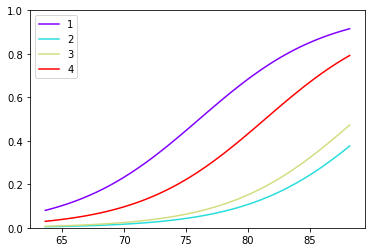

In [22]:
plotter = Plotter('_outputs/plots')
plotter.plot_mean_trajectory(leaspy.model, labels=['1', '2', '3', '4'])


# Step 3. Personalize the model to individual data

### - Reconstruction

In [23]:
settings = AlgorithmSettings('scipy_minimize')


In [24]:
results = leaspy.personalize(data, settings)

Replacing n_burn_in_iter parameter from value 200 to value 200
Replacing n_iter parameter from value 701 to value 701
Replacing eps parameter from value 0.005 to value 0.005
Replacing L parameter from value 10 to value 10
Replacing annealing parameter from value {'do_annealing': True, 'initial_temperature': 300, 'n_plateau': 10, 'n_iter': 200} to value {'do_annealing': True, 'initial_temperature': 300, 'n_plateau': 10, 'n_iter': 200}


In [68]:
print(data.get_indices())

['116', '142', '169', '178', '200', '225', '296', '307', '377', '448', '546', '557', '626', '644', '673', '698', '709', '800', '802', '867', '908', '914', '919', '925', '989', '1032', '1034', '1040', '1045', '1046', '1052', '1072', '1074', '1122', '1131', '1155', '1186', '1187', '1218', '1269', '1300', '1378', '1408', '1414', '1417', '1419', '107', '150', '501', '505', '679', '715', '746', '770', '1118', '1246', '1260', '1380', '1418', '2002', '2026', '2027', '2031', '2036', '2037', '2042', '2043', '2045', '2052', '2055', '2058', '2060', '2061', '2063', '2068', '2072', '2073', '2074', '2077', '2079', '2083', '2087', '2093', '2099', '2100', '2109', '2116', '2119', '2121', '2123', '2124', '2125', '2130', '2133', '2142', '2148', '2151', '2153', '2155', '2164', '2167', '2168', '2171', '2180', '2182', '2183', '2184', '2185', '2187', '2190', '2191', '2193', '2195', '2196', '2200', '2205', '2208', '2210', '2213', '2219', '2220', '2225', '2238', '2239', '2240', '2245', '2247', '2249', '2264', 

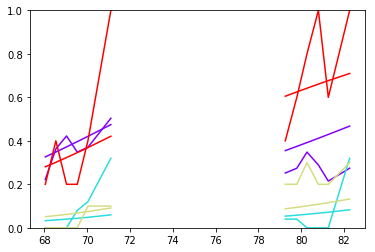

In [67]:
plotter.plot_patient_trajectory(leaspy.model, results, ['4346', '4206'])

### - Analysis

In [ ]:
results.

In [ ]:
plotter.plot_distribution(results, by="gender", parameter="xi")